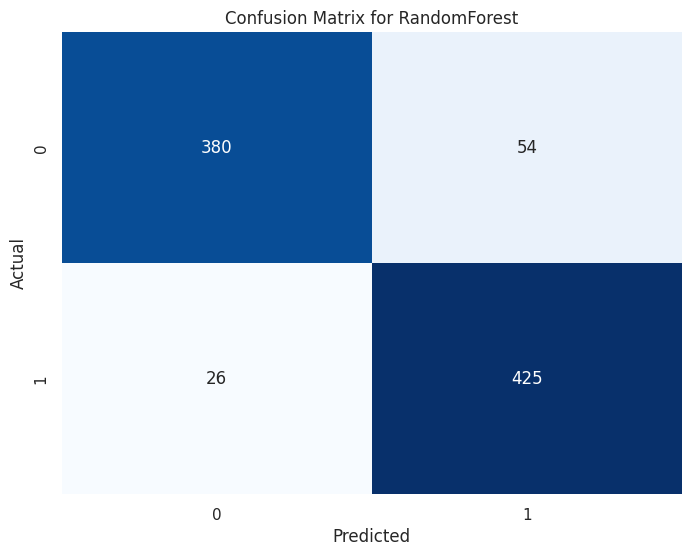

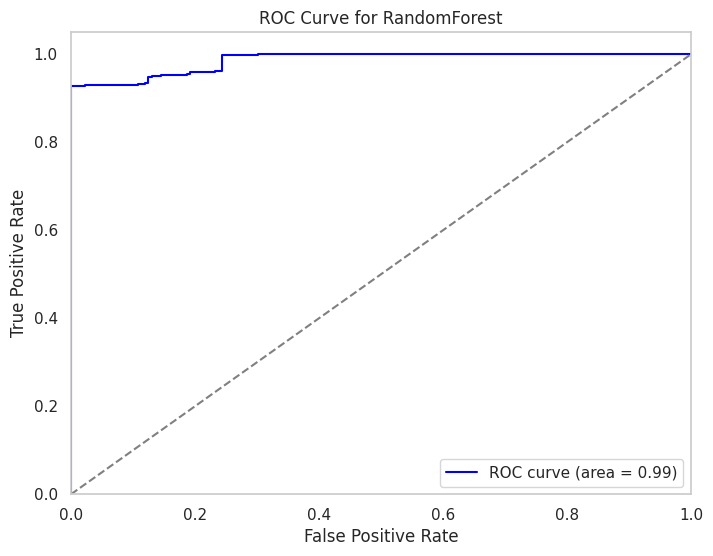

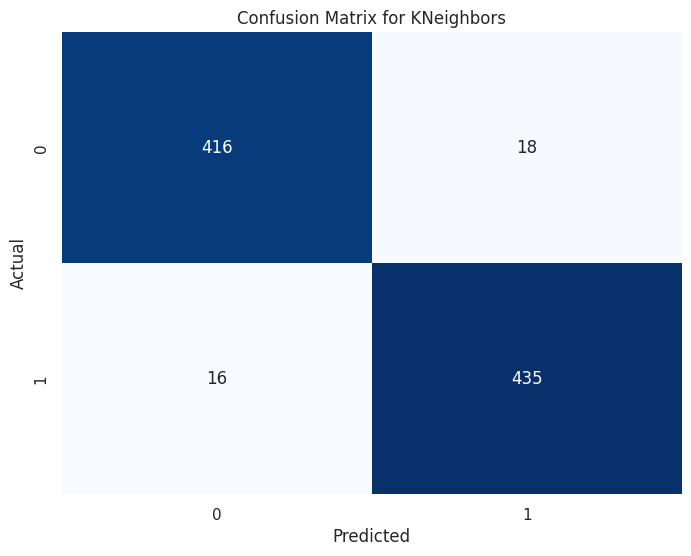

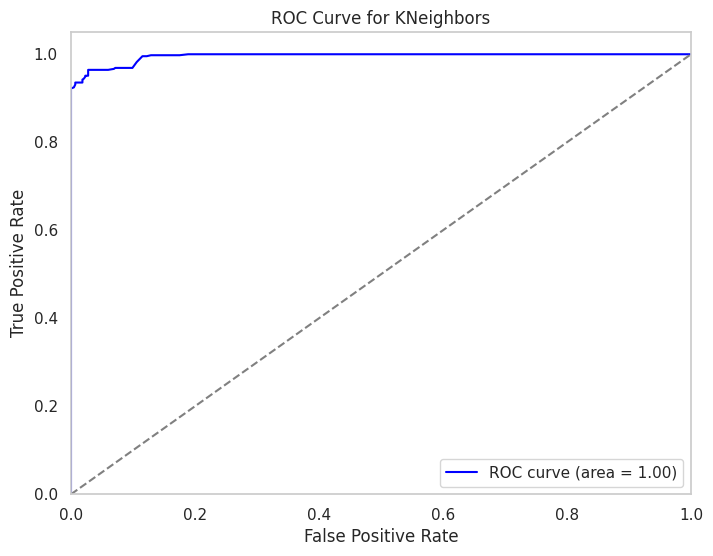

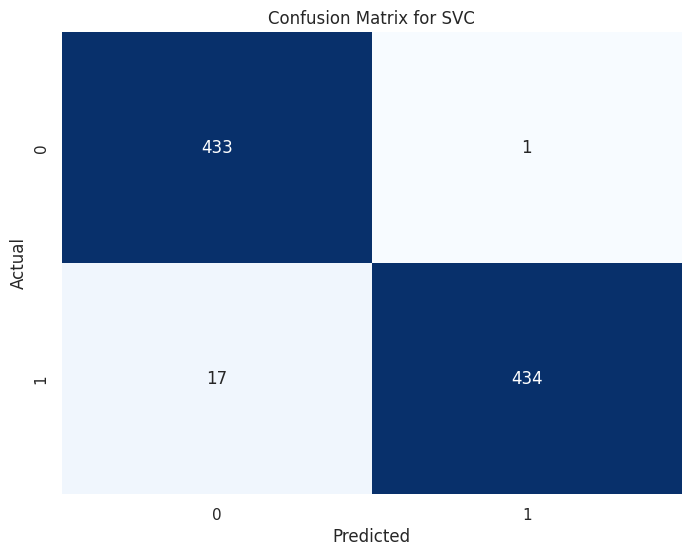

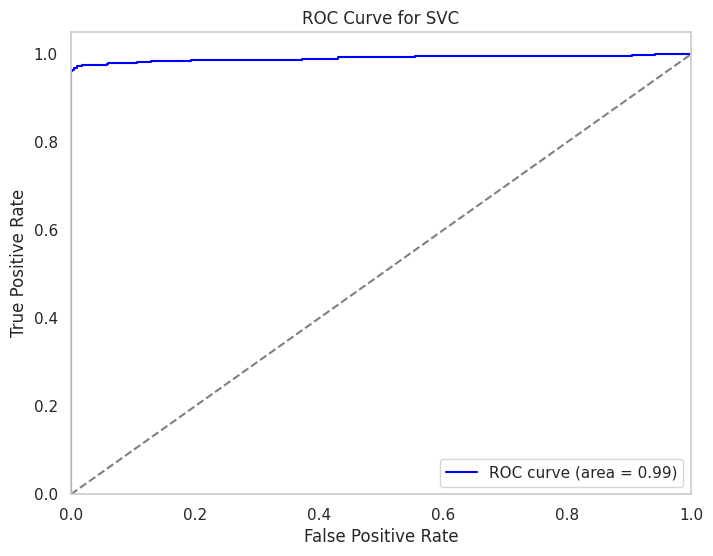

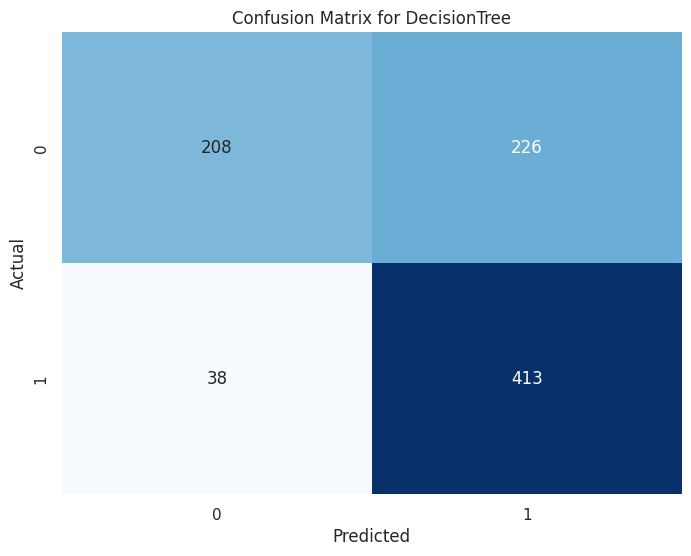

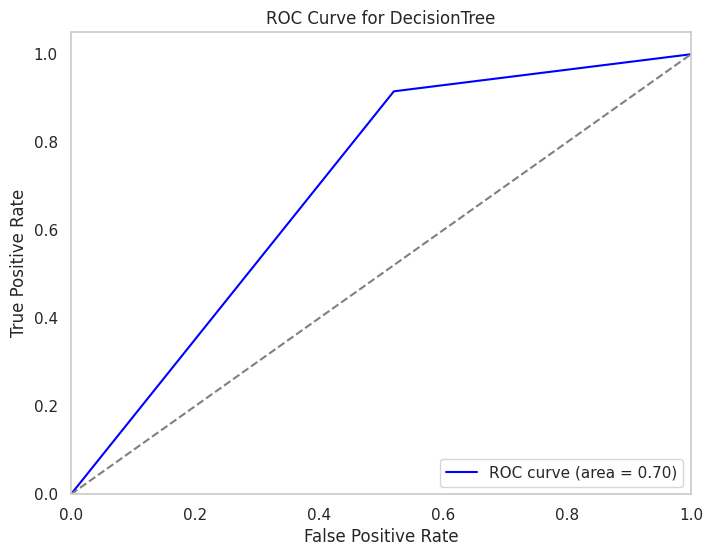

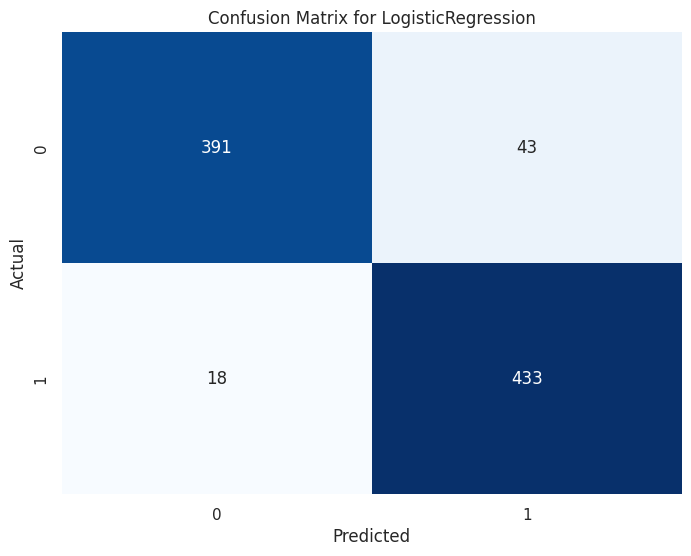

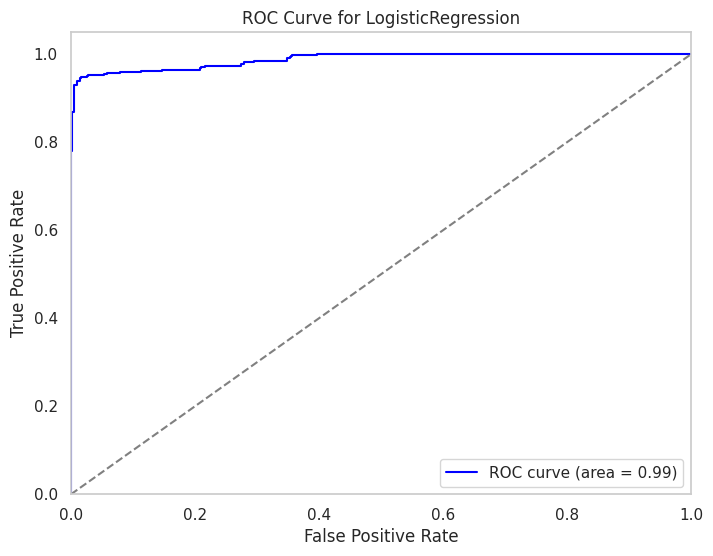

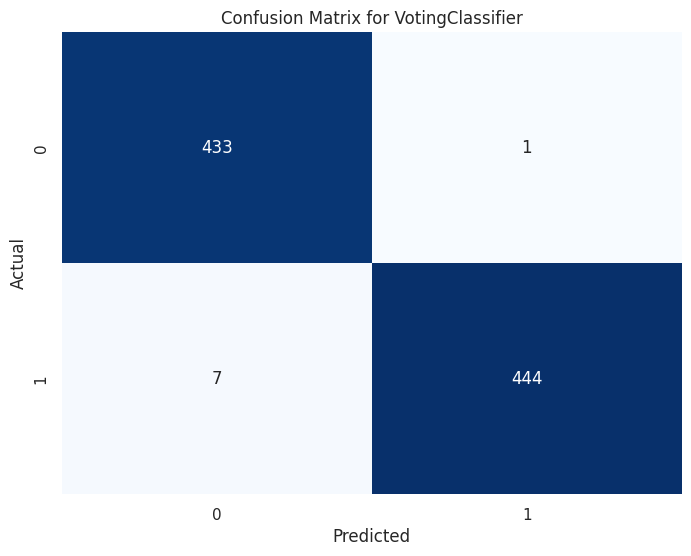

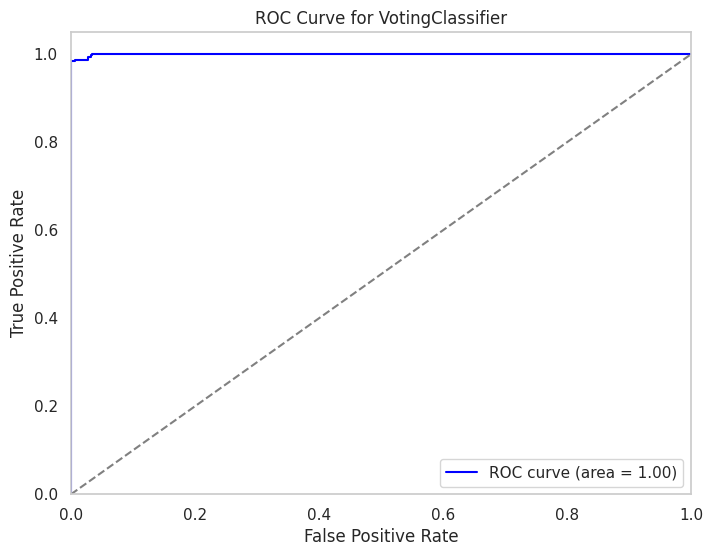

           Classifier  Accuracy  Precision    Recall  F1 Score       TPR  \
0        RandomForest  0.909605   0.911145  0.909605  0.909459  0.942350   
1          KNeighbors  0.961582   0.961588  0.961582  0.961580  0.964523   
2                 SVC  0.979661   0.980302  0.979661  0.979661  0.962306   
3        DecisionTree  0.701695   0.744012  0.701695  0.686184  0.915743   
4  LogisticRegression  0.931073   0.932382  0.931073  0.930981  0.960089   
5    VotingClassifier  0.990960   0.991053  0.990960  0.990961  0.984479   

        FNR       TNR       FPR  Training Time  Testing Time  
0  0.057650  0.875576  0.124424       0.294771      0.011777  
1  0.035477  0.958525  0.041475       0.004976      0.121226  
2  0.037694  0.997696  0.002304       0.654562      0.021652  
3  0.084257  0.479263  0.520737       0.002385      0.000247  
4  0.039911  0.900922  0.099078       0.016059      0.000502  
5  0.015521  0.997696  0.002304       0.956499      0.171309  


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize  # Moved label_binarize import
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve,
    roc_auc_score, auc, precision_score, recall_score, f1_score
)
import time

# Load the dataset
df = pd.read_csv("/kaggle/input/dropout22/Selected_Features.csv")

# Prepare data
X = df.drop('Target', axis=1)
y = df['Target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize base classifiers
clf1 = RandomForestClassifier(n_estimators=100, max_depth=1)
# clf3 = XGBClassifier(n_estimators=1, max_depth=1, learning_rate=10.0, gamma=10, subsample=0.1, colsample_bytree=0.1, use_label_encoder=False, eval_metric='mlogloss')
clf4 = KNeighborsClassifier(n_neighbors=100)
clf5 = SVC(kernel='sigmoid', C=0.1, probability=True)
clf6 = DecisionTreeClassifier(max_depth=1, min_samples_split=10, min_samples_leaf=5, max_features=1)
clf7 = LogisticRegression(C=0.001)

# Create a voting classifier
voting_clf = VotingClassifier(
    estimators=[('rf', clf1), ('knn', clf4), ('svc', clf5), ('dt', clf6), ('lr', clf7)],
    voting='soft'
)

classifiers = [clf1, clf4, clf5, clf6, clf7, voting_clf]
classifier_names = ['RandomForest',  'KNeighbors', 'SVC', 'DecisionTree', 'LogisticRegression', 'VotingClassifier']

results = []
training_times = []
testing_times = []
# Train and test classifiers
for clf, name in zip(classifiers, classifier_names):
    start_train = time.time()
    clf.fit(X_train_scaled, y_train)
    end_train = time.time()
    
    start_test = time.time()
    y_pred = clf.predict(X_test_scaled)
    end_test = time.time()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
   
    
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fnr = fn / (tp + fn) if (tp + fn) != 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0
    fpr = fp / (tn + fp) if (tn + fp) != 0 else 0
    results.append([name, accuracy, precision, recall, f1,tpr,fnr,tnr,fpr,end_train - start_train, end_test - start_test])
    # Print confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.savefig(f"/kaggle/working/confusion_matrix_{name}.png")
    plt.show()
    
    # Calculate ROC Curve
    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    y_score = clf.predict_proba(X_test_scaled)[:, 1] if hasattr(clf, "predict_proba") else y_pred
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig(f"/kaggle/working/roc_curve_{name}.png")
    plt.show()
   
# Create the results dataframe
results_df = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score','TPR', 'FNR', 'TNR', 'FPR','Training Time', 'Testing Time'])


# Display the results
print(results_df)


In [37]:
import joblib  # For saving the model
# Save the model to a file
model_filename = 'voting_classifier_model.pkl'
joblib.dump(voting_clf, model_filename)

print(f"Model saved as {model_filename}")

Model saved as voting_classifier_model.pkl


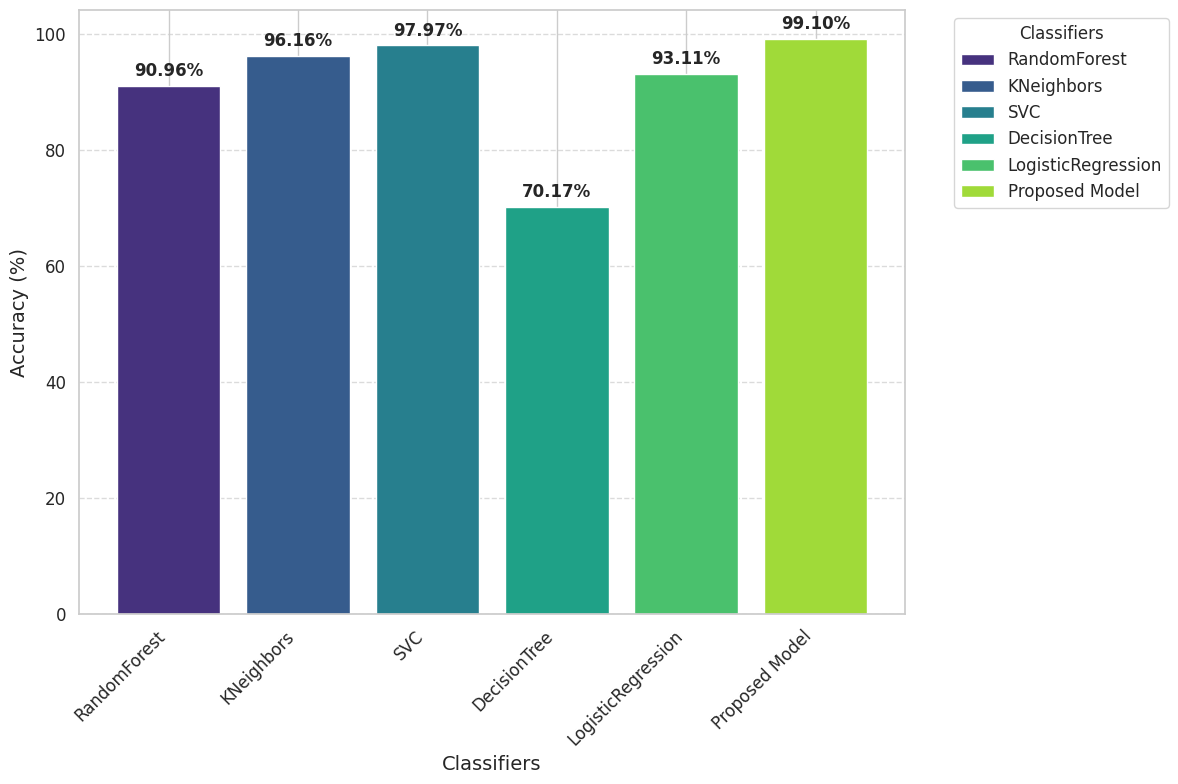

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'classifier_names' and 'results_df' are defined and available
classifier_names[-1] = 'Proposed Model'  # Rename the last classifier

# Bar diagram for classifier accuracies with enhancements
plt.figure(figsize=(12, 8))

# Use seaborn to make the plot more attractive
sns.set(style="whitegrid")
colors = sns.color_palette("viridis", len(classifier_names))
bars = plt.bar(classifier_names, results_df['Accuracy'] * 100, color=colors)

# Add titles and labels with customized font sizes
plt.xlabel('Classifiers', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, f"{yval:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add a grid for better visual reference
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(bars, classifier_names, title="Classifiers", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Random Forest

In [39]:
import shap                                                       # SHAP values >> contributions of each feature to a model's prediction for a single instance of data

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(clf1)
shap_values = explainer.shap_values(X_train) 


In [40]:
#Dropout class
import matplotlib.pyplot as plt
shap_values_class_1 = shap_values[0]

# Visualize the first prediction's explanation for the positive class
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_class_1[0, :], X_train.iloc[0, :])


In [41]:

shap_values_class_0 = shap_values[1]

# Visualize the first prediction's explanation for the positive class
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_class_0[0, :], X_train.iloc[0, :])


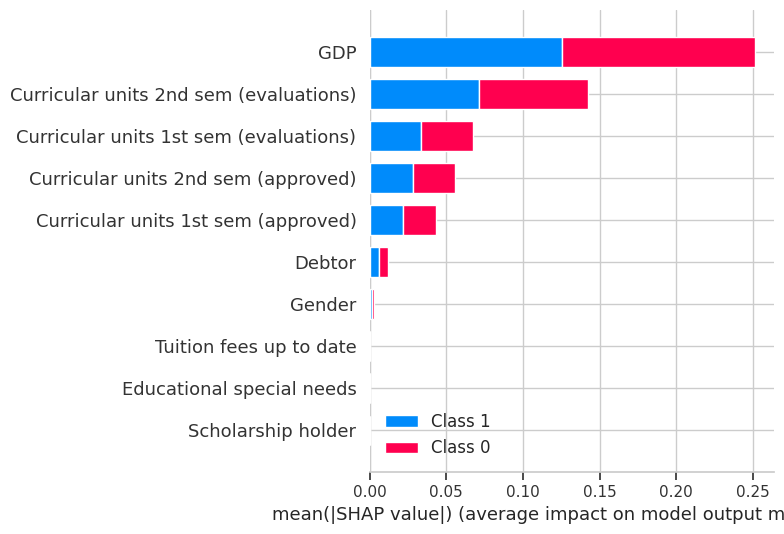

In [42]:
shap_values = shap.TreeExplainer(clf1).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

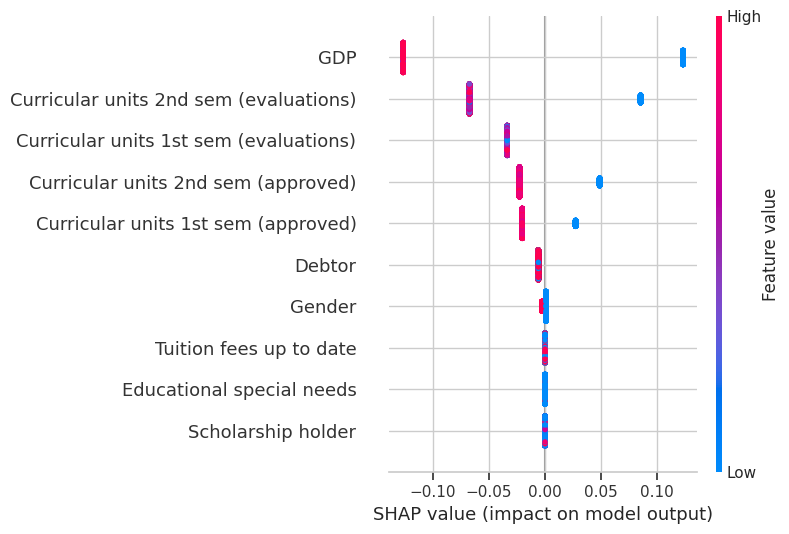

In [43]:
shap.summary_plot(shap_values[0], X_train)

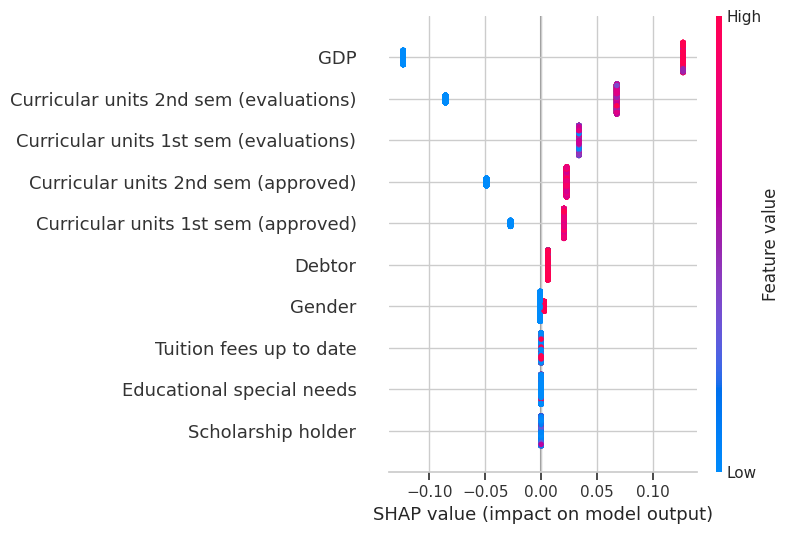

In [44]:
shap.summary_plot(shap_values[1], X_train)

# KNN

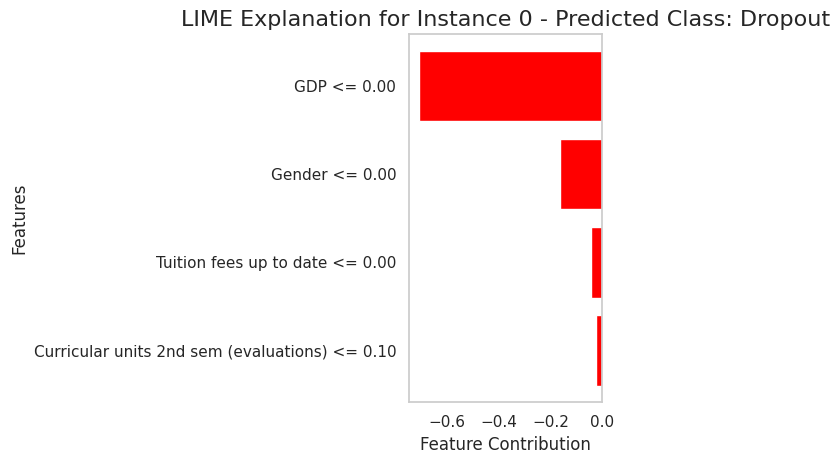

In [45]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Get the class names
class_names = ['Dropout', 'Graduate']

# Get the feature names
feature_names = list(X_test.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names=feature_names,
                                 class_names=class_names, 
                                 mode='classification')

# Choose an instance from the test set to explain
i = 0  # Index of the instance to explain
instance = X_test.iloc[i].values

# Generate the explanation for the selected instance
explanation = explainer.explain_instance(instance,
                                         clf4.predict_proba,
                                         num_features=4)  # You can adjust the number of features to display

# Visualize the explanation with enhanced formatting and save it in high quality
fig = explanation.as_pyplot_figure()

# Get the predicted class and probability
predicted_class_index = clf4.predict(instance.reshape(1, -1))[0]
predicted_class = class_names[predicted_class_index]
predicted_proba = clf4.predict_proba(instance.reshape(1, -1)).max()

# Add title with predicted class
plt.title(f'LIME Explanation for Instance {i} - Predicted Class: {predicted_class}', fontsize=16)
plt.xlabel('Feature Contribution', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(False)  # Optionally turn off grid lines
plt.tight_layout()

# Save the figure in high quality
fig.savefig('knn_dropout.png', bbox_inches='tight', dpi=300)

# Show the saved image (optional)
plt.show()


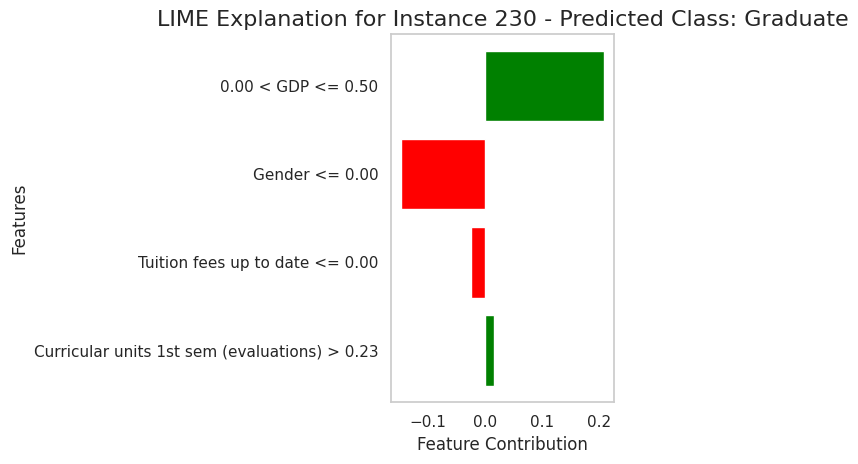

In [46]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Get the class names
class_names = ['Dropout', 'Graduate']

# Get the feature names
feature_names = list(X_test.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names=feature_names,
                                 class_names=class_names, 
                                 mode='classification')

# Choose an instance from the test set to explain
i = 230  # Index of the instance to explain
instance = X_test.iloc[i].values

# Generate the explanation for the selected instance
explanation = explainer.explain_instance(instance,
                                         clf4.predict_proba,
                                         num_features=4)  # You can adjust the number of features to display

# Visualize the explanation with enhanced formatting and save it in high quality
fig = explanation.as_pyplot_figure()

# Get the predicted class and probability
predicted_class_index = clf4.predict(instance.reshape(1, -1))[0]
predicted_class = class_names[predicted_class_index]
predicted_proba = clf4.predict_proba(instance.reshape(1, -1)).max()

# Add title with predicted class
plt.title(f'LIME Explanation for Instance {i} - Predicted Class: {predicted_class}', fontsize=16)
plt.xlabel('Feature Contribution', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(False)  # Optionally turn off grid lines
plt.tight_layout()

# Save the figure in high quality
fig.savefig('knn_graduate.png', bbox_inches='tight', dpi=300)

# Show the saved image (optional)
plt.show()


# SVM

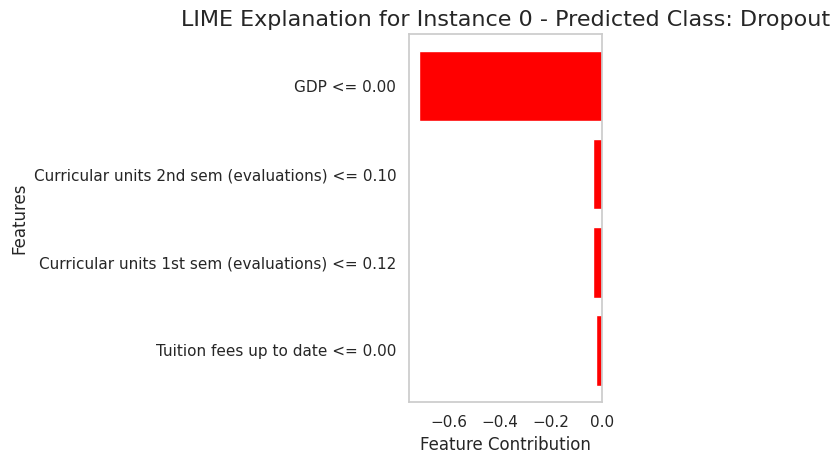

In [47]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Get the class names
class_names = ['Dropout', 'Graduate']

# Get the feature names
feature_names = list(X_test.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names=feature_names,
                                 class_names=class_names, 
                                 mode='classification')

# Choose an instance from the test set to explain
i = 0  # Index of the instance to explain
instance = X_test.iloc[i].values

# Generate the explanation for the selected instance
explanation = explainer.explain_instance(instance,
                                         clf5.predict_proba,
                                         num_features=4)  # You can adjust the number of features to display

# Visualize the explanation with enhanced formatting and save it in high quality
fig = explanation.as_pyplot_figure()

# Get the predicted class and probability
predicted_class_index = clf4.predict(instance.reshape(1, -1))[0]
predicted_class = class_names[predicted_class_index]
predicted_proba = clf4.predict_proba(instance.reshape(1, -1)).max()

# Add title with predicted class
plt.title(f'LIME Explanation for Instance {i} - Predicted Class: {predicted_class}', fontsize=16)
plt.xlabel('Feature Contribution', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(False)  # Optionally turn off grid lines
plt.tight_layout()

# Save the figure in high quality
fig.savefig('SVM_dropout.png', bbox_inches='tight', dpi=300)

# Show the saved image (optional)
plt.show()

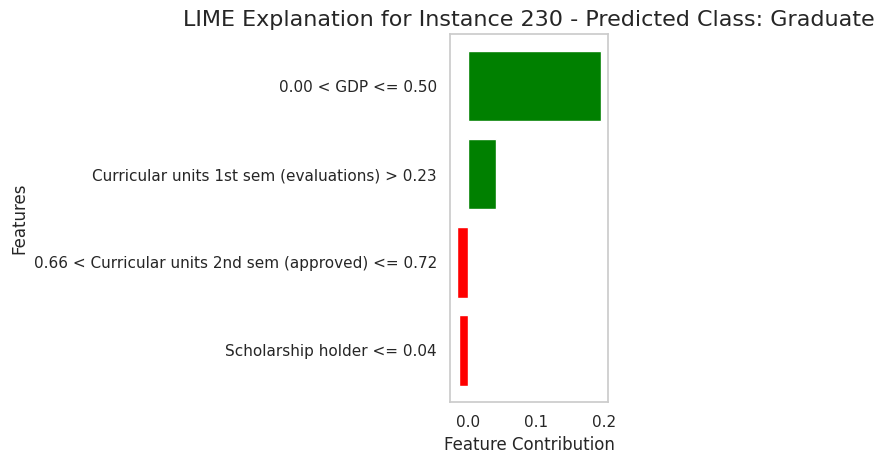

In [48]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Get the class names
class_names = ['Dropout', 'Graduate']

# Get the feature names
feature_names = list(X_test.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names=feature_names,
                                 class_names=class_names, 
                                 mode='classification')

# Choose an instance from the test set to explain
i = 230  # Index of the instance to explain
instance = X_test.iloc[i].values

# Generate the explanation for the selected instance
explanation = explainer.explain_instance(instance,
                                         clf5.predict_proba,
                                         num_features=4)  # You can adjust the number of features to display

# Visualize the explanation with enhanced formatting and save it in high quality
fig = explanation.as_pyplot_figure()

# Get the predicted class and probability
predicted_class_index = clf5.predict(instance.reshape(1, -1))[0]
predicted_class = class_names[predicted_class_index]
predicted_proba = clf4.predict_proba(instance.reshape(1, -1)).max()

# Add title with predicted class
plt.title(f'LIME Explanation for Instance {i} - Predicted Class: {predicted_class}', fontsize=16)
plt.xlabel('Feature Contribution', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(False)  # Optionally turn off grid lines
plt.tight_layout()

# Save the figure in high quality
fig.savefig('svm_graduate.png', bbox_inches='tight', dpi=300)

# Show the saved image (optional)
plt.show()

# Decision Tree

In [49]:
import shap                                                       # SHAP values >> contributions of each feature to a model's prediction for a single instance of data

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(clf6)
shap_values = explainer.shap_values(X_train) 

In [50]:

shap_values_class_1 = shap_values[0]

# Visualize the first prediction's explanation for the positive class
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_class_1[0, :], X_train.iloc[0, :])

In [51]:

shap_values_class_0 = shap_values[1]

# Visualize the first prediction's explanation for the positive class
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_class_0[0, :], X_train.iloc[0, :])


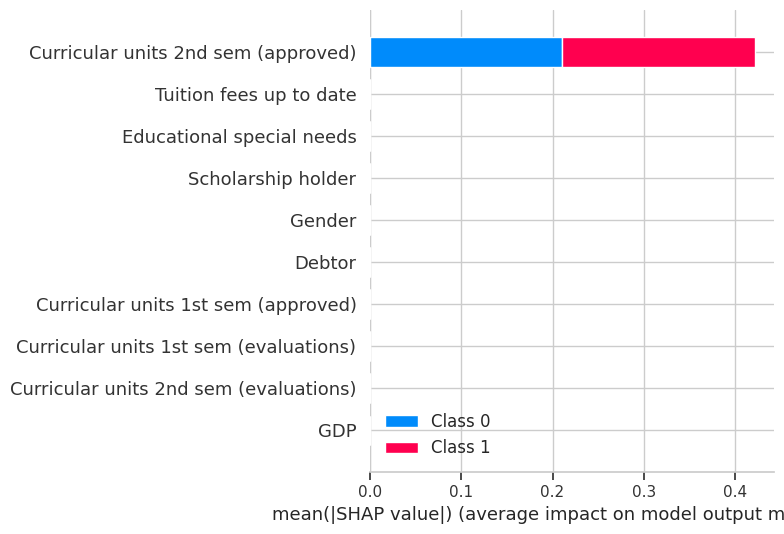

In [52]:
shap_values = shap.TreeExplainer(clf6).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

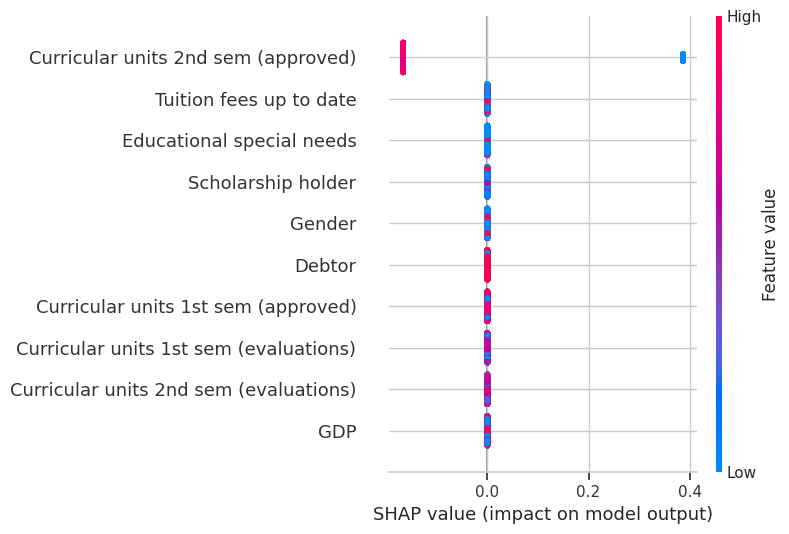

In [53]:
shap.summary_plot(shap_values[0], X_train)

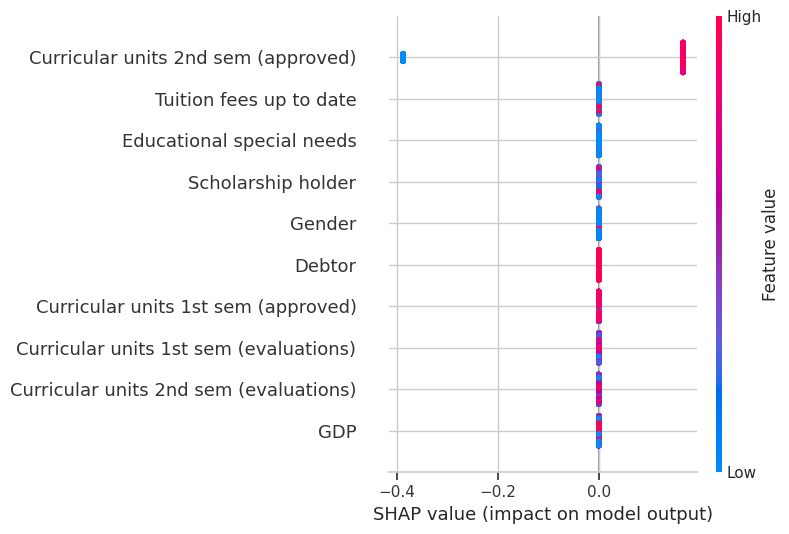

In [54]:
shap.summary_plot(shap_values[1], X_train)

# Logistic Regression

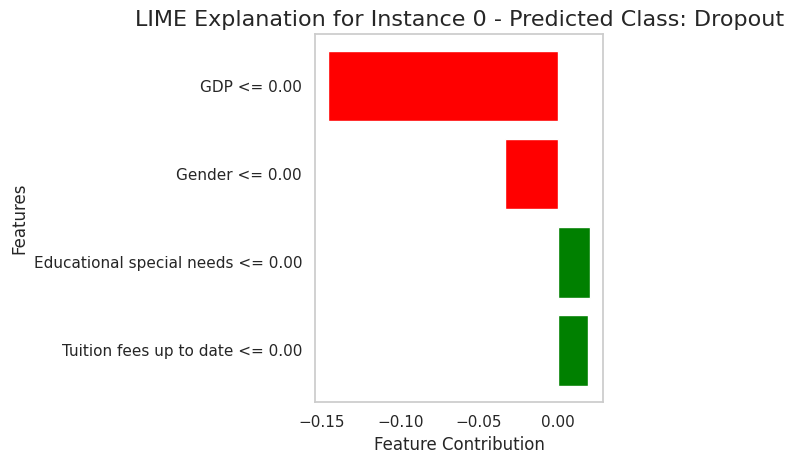

In [55]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Get the class names
class_names = ['Dropout', 'Graduate']

# Get the feature names
feature_names = list(X_test.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names=feature_names,
                                 class_names=class_names, 
                                 mode='classification')

# Choose an instance from the test set to explain
i = 0  # Index of the instance to explain
instance = X_test.iloc[i].values

# Generate the explanation for the selected instance
explanation = explainer.explain_instance(instance,
                                         clf7.predict_proba,
                                         num_features=4)  # You can adjust the number of features to display

# Visualize the explanation with enhanced formatting and save it in high quality
fig = explanation.as_pyplot_figure()

# Get the predicted class and probability
predicted_class_index = clf4.predict(instance.reshape(1, -1))[0]
predicted_class = class_names[predicted_class_index]
predicted_proba = clf4.predict_proba(instance.reshape(1, -1)).max()

# Add title with predicted class
plt.title(f'LIME Explanation for Instance {i} - Predicted Class: {predicted_class}', fontsize=16)
plt.xlabel('Feature Contribution', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(False)  # Optionally turn off grid lines
plt.tight_layout()

# Save the figure in high quality
fig.savefig('logistic_regression_dropout.png', bbox_inches='tight', dpi=300)

# Show the saved image (optional)
plt.show()

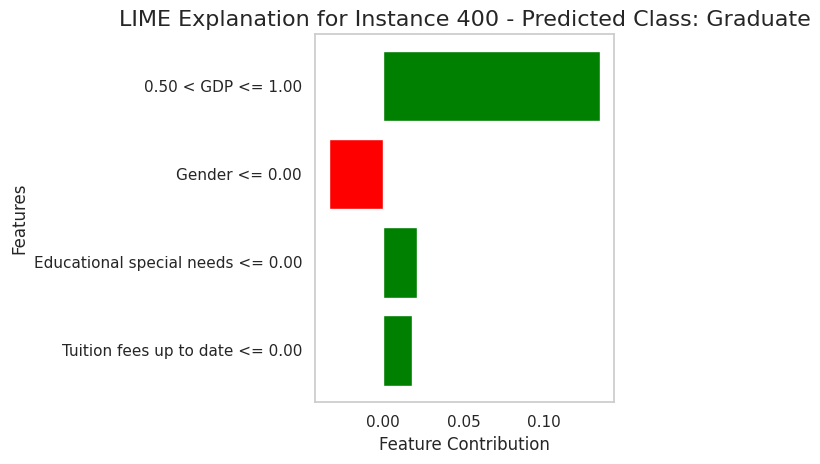

In [56]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Get the class names
class_names = ['Dropout', 'Graduate']

# Get the feature names
feature_names = list(X_test.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names=feature_names,
                                 class_names=class_names, 
                                 mode='classification')

# Choose an instance from the test set to explain
i = 400 # Index of the instance to explain
instance = X_test.iloc[i].values

# Generate the explanation for the selected instance
explanation = explainer.explain_instance(instance,
                                         clf7.predict_proba,
                                         num_features=4)  # You can adjust the number of features to display

# Visualize the explanation with enhanced formatting and save it in high quality
fig = explanation.as_pyplot_figure()

# Get the predicted class and probability
predicted_class_index = clf4.predict(instance.reshape(1, -1))[0]
predicted_class = class_names[predicted_class_index]
predicted_proba = clf4.predict_proba(instance.reshape(1, -1)).max()

# Add title with predicted class
plt.title(f'LIME Explanation for Instance {i} - Predicted Class: {predicted_class}', fontsize=16)
plt.xlabel('Feature Contribution', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(False)  # Optionally turn off grid lines
plt.tight_layout()

# Save the figure in high quality
fig.savefig('logistic_regression_graduate.png', bbox_inches='tight', dpi=300)

# Show the saved image (optional)
plt.show()

# Proposed Model

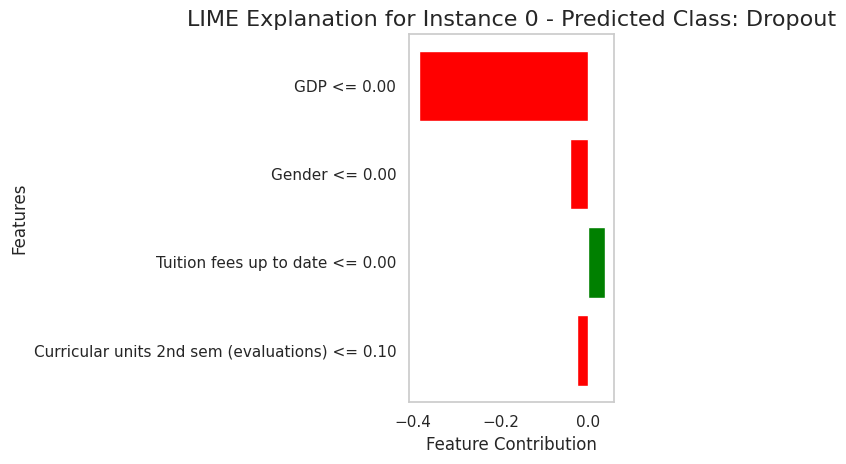

In [57]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Get the class names
class_names = ['Dropout', 'Graduate']

# Get the feature names
feature_names = list(X_test.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names=feature_names,
                                 class_names=class_names, 
                                 mode='classification')

# Choose an instance from the test set to explain
i = 0  # Index of the instance to explain
instance = X_test.iloc[i].values

# Generate the explanation for the selected instance
explanation = explainer.explain_instance(instance,
                                         voting_clf.predict_proba,
                                         num_features=4)  # You can adjust the number of features to display

# Visualize the explanation with enhanced formatting and save it in high quality
fig = explanation.as_pyplot_figure()

# Get the predicted class and probability
predicted_class_index = clf4.predict(instance.reshape(1, -1))[0]
predicted_class = class_names[predicted_class_index]
predicted_proba = clf4.predict_proba(instance.reshape(1, -1)).max()

# Add title with predicted class
plt.title(f'LIME Explanation for Instance {i} - Predicted Class: {predicted_class}', fontsize=16)
plt.xlabel('Feature Contribution', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(False)  # Optionally turn off grid lines
plt.tight_layout()

# Save the figure in high quality
fig.savefig('proposed_model_dropout.png', bbox_inches='tight', dpi=300)

# Show the saved image (optional)
plt.show()

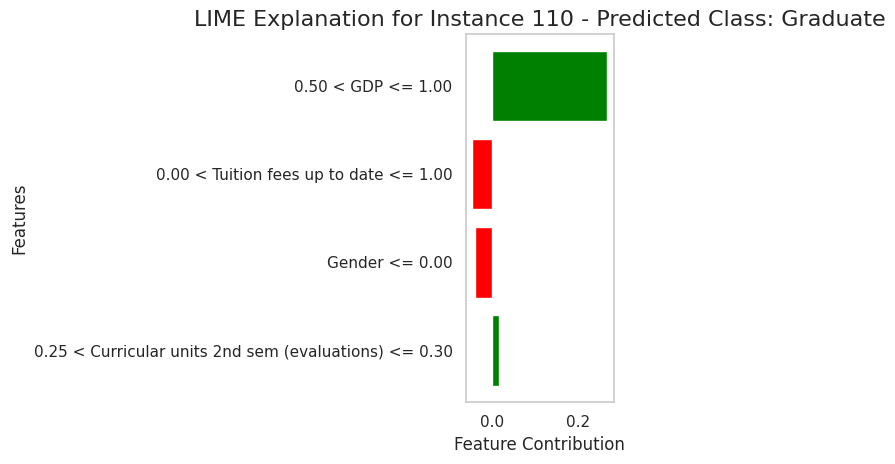

In [58]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Get the class names
class_names = ['Dropout', 'Graduate']

# Get the feature names
feature_names = list(X_test.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names=feature_names,
                                 class_names=class_names, 
                                 mode='classification')

# Choose an instance from the test set to explain
i = 110  # Index of the instance to explain
instance = X_test.iloc[i].values

# Generate the explanation for the selected instance
explanation = explainer.explain_instance(instance,
                                         voting_clf.predict_proba,
                                         num_features=4)  # You can adjust the number of features to display

# Visualize the explanation with enhanced formatting and save it in high quality
fig = explanation.as_pyplot_figure()

# Get the predicted class and probability
predicted_class_index = clf4.predict(instance.reshape(1, -1))[0]
predicted_class = class_names[predicted_class_index]
predicted_proba = clf4.predict_proba(instance.reshape(1, -1)).max()

# Add title with predicted class
plt.title(f'LIME Explanation for Instance {i} - Predicted Class: {predicted_class}', fontsize=16)
plt.xlabel('Feature Contribution', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(False)  # Optionally turn off grid lines
plt.tight_layout()

# Save the figure in high quality
fig.savefig('proposed_model_graduate.png', bbox_inches='tight', dpi=300)

# Show the saved image (optional)
plt.show()